# py2cytoscape: View API Examples
----

![](http://cl.ly/image/2k2N22123H0G/p2c_demo2.gif)

## Introduction

This is a sample Jupyter Notebook to demonstrate how users can manipulate Cytoscape network views directly from Python code.

## What are the differences between Style API and View API?
py2cytoscpae already has the Style API to create and update _Visual Styles_.  There are different use cases for these two APIs:

### Style API
* Standard way to create Cytoscape visualizations
* Creates Visual Stye - can be applied to any networks

#### Use cases
* Data-driven visualizations - Control views with attribute values

### View API
* Directly updates current view objects (independent from Styles).
    
#### Use Cases
* __Create your own layout algorithms__
* __Create annimations__
    

## Basic Setup

* Import required packages
* Load a network(s)

In [1]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient

import pandas as pd
import json

# Create REST client for Cytoscape
cy = CyRestClient()

# Reset current session for fresh start
cy.session.delete()

# Load a sample network
network1 = cy.network.create_from('http://chianti.ucsd.edu/~kono/data/galFiltered.sif')

# You can check all available Visual Properties with this function call:
vps = pd.Series(cy.style.vps.get_all())
vps.head(20)

DING_RENDERING_ENGINE_ROOT            Ding Rndering Engine Root Visual Property
EDGE                                                       Edge Visual Property
EDGE_BEND                                                             Edge Bend
EDGE_CURVED                                                         Edge Curved
EDGE_LABEL                                                           Edge Label
EDGE_LABEL_COLOR                                               Edge Label Color
EDGE_LABEL_FONT_FACE                                       Edge Label Font Face
EDGE_LABEL_FONT_SIZE                                       Edge Label Font Size
EDGE_LABEL_TRANSPARENCY                                 Edge Label Transparency
EDGE_LINE_TYPE                                                   Edge Line Type
EDGE_PAINT                                                           Edge Paint
EDGE_SELECTED                                                     Edge Selected
EDGE_SELECTED_PAINT                     

## Get Network View Object

There are twol options to get current views from Cytoscape:

* Get as _CyNetworkView_ custom Python object
* Get as Cytoscape.js JSON dictionary

### 1: Get as CyNetworkView
CyNetworkView is a _reference_ to a network view in your current Cytoscape session.  This means CyNetworkView objects do not include actual data, such as node size or edge stroke colors.  Instead, they hold a location of the data and create actual REST calls when you execute get/update methods for nodes and edges. 

In [2]:
# Get views for a network: Cytoscape "may" have multiple views, and that's why it returns list instead of an object.
view_id_list = network1.get_views() 

# Display IDs of available views
print(view_id_list)

# The "format" option specify the return type.
view1 = network1.get_view(view_id_list[0], format='view')

# This is a CyNetworkView object, not dictionary
print(view1)

[23617]


### 2: Get as Cytoscape.js JSON Dictionary

If you prefer standard Python objects, you can use 'json' option to get Cytoscape network as __Cytoscape.js style JSON__.  This is a network plus (x, y) locations.  it __DOES NOT__ includes any other view information.

In [3]:
view2 = network1.get_view(view_id_list[0], format='json')
#print(view2)

## Access Node / Edge View Objects from CyNetworkView

Once you have __CyNetworkView__ object, you have access to all _Visual Properties_ for nodes, edges, and the network.

In [4]:
# Get node/edge views as a Python dictionary
node_views_dict = view1.get_node_views_as_dict() 
edge_views_dict = view1.get_edge_views_as_dict() 

#print(json.dumps(node_views_dict, indent=4))
#print(json.dumps(edge_views_dict, indent=4))

### Convert to Pandas Data Frame
Since it's a simple dictionary, you can easily convert it into Data Frame.

In [5]:
# Convert it into Pandas DataFrame
nv_df = pd.DataFrame.from_dict(node_views_dict, orient='index' )

# Extract specific Visual Property values...
node_location_df = nv_df[['NODE_X_LOCATION', 'NODE_Y_LOCATION']]
node_location_df.head()

,NODE_X_LOCATION,NODE_Y_LOCATION
22924,-680,100
22925,-680,-300
22927,-120,-140
22928,-360,340
22930,-600,-20


In [15]:
# Get views as NodeView/EdgeView objects
node_views = view1.get_node_views()

# Pick the first node view object
nv1 = node_views[0]

# Get details about the node
nv1_values = nv1.get_values()

# Convert to Data Frame
single_node_df = pd.DataFrame.from_dict(nv1_values, orient='index')
single_node_df.tail(20)

,0
NODE_TOOLTIP,
NODE_DEPTH,0
NODE_LABEL_WIDTH,200
NODE_LABEL_FONT_SIZE,12
NODE_CUSTOMGRAPHICS_9,org.cytoscape.ding.customgraphics.NullCustomGr...
NODE_CUSTOMGRAPHICS_8,org.cytoscape.ding.customgraphics.NullCustomGr...
NODE_CUSTOMGRAPHICS_5,org.cytoscape.ding.customgraphics.NullCustomGr...
NODE_CUSTOMGRAPHICS_4,org.cytoscape.ding.customgraphics.NullCustomGr...
NODE_BORDER_STROKE,SOLID
NODE_CUSTOMGRAPHICS_6,org.cytoscape.ding.customgraphics.NullCustomGr...


In [16]:
# Access single value
nv1_color = nv1.get_value('NODE_FILL_COLOR')
print(nv1_color)

#0099CC


## Directly set Visual Property values

Setting values are also easy with py2cytoscape.  All you have to do is creating a dictionary for the target nodes and edges.

### Important: Performance

If you call get/set methods for single node/edge view, it actually calls Cytoscape REST API through HTTP.  __If you need to update hundreds or thousands of nodes/edges, I strongly recommend update multiple objects at once__.

### Example 1: Set random colors to nodes

In [53]:
# Switch current visual stye to a simple one...
minimal_style = cy.style.create('Minimal')
cy.style.apply(style=minimal_style, network=network1)

# Change background color:  simply pass key-value pair
view1.update_network_view(visual_property='NETWORK_BACKGROUND_PAINT', value='black')

# Get SUID of all nodes
target_nodes = network1.get_nodes()

# Generate random colors for each node
import random

def get_color():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return '#' + hex(r)[2:] + hex(g)[2:] + hex(b)[2:]

# Assign key-value pair.  For this example, node SUID to color.
def generate_randome_color_dict(node_ids):
    new_values = {}
    for n in node_ids:
        new_values[n] = get_color()
    return new_values

new_values = generate_randome_color_dict(target_nodes)

# Set new values for a set of nodes.  In this case, all nodes in the network
view1.update_node_views(visual_property='NODE_FILL_COLOR', values=new_values)

Now you can see something like this in the Cytoscape window.  Let's embed the view as a static PNG image:

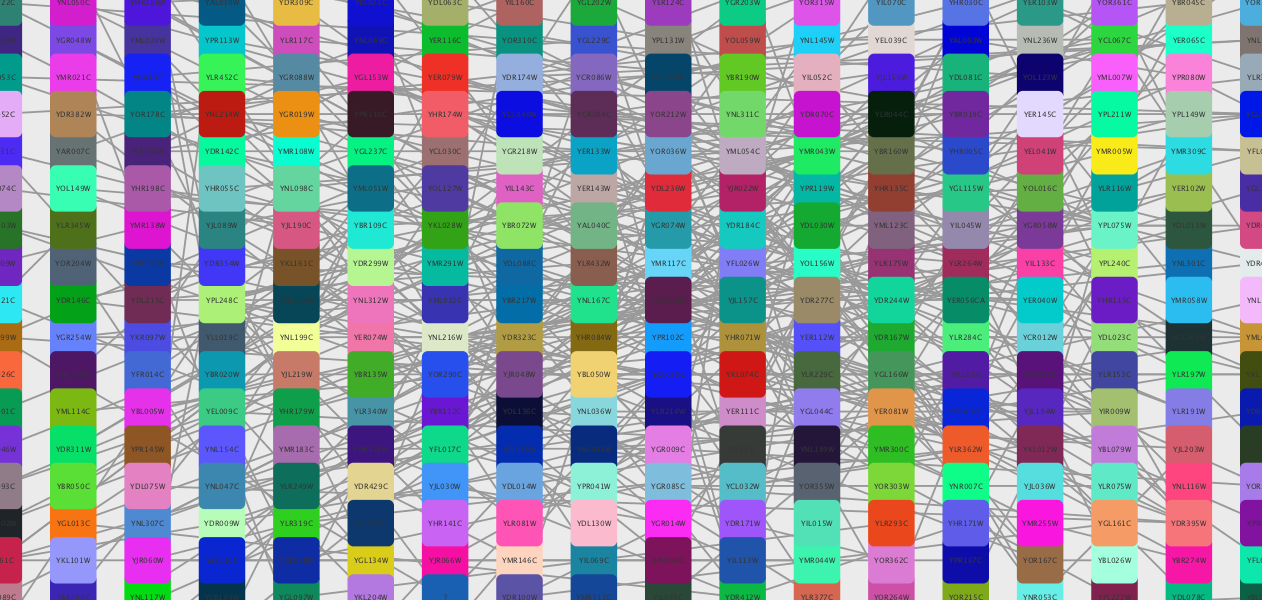

In [30]:
from IPython.display import Image
Image(network1.get_png())

### Example 2: Custom Layout - Draw Sine Wave with nodes

Creating a custom layout programmatically is easy with py2cytoscape:

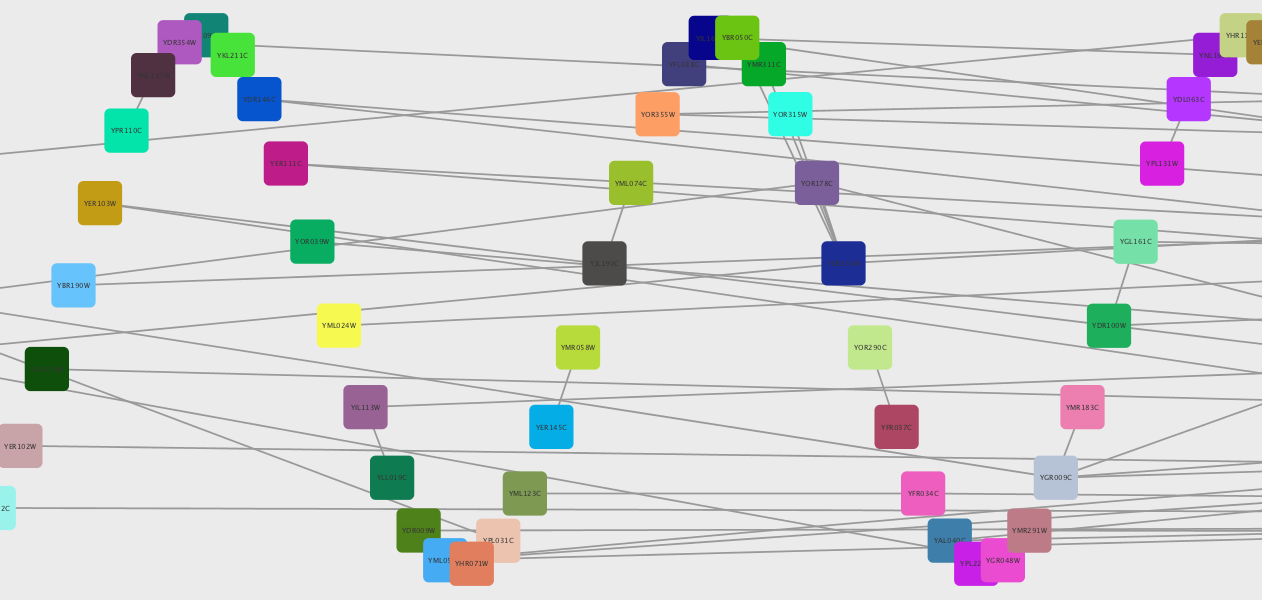

In [50]:
import math
all_nodes = network1.get_nodes()

idx = 0
x_locations = {}
for n in all_nodes:
    x_locations[n] = idx*30
    idx += 1
    
idx = 0
y_locations = {}
for n in all_nodes:
    y_locations[n] = math.sin(idx/math.pi)*300
    idx += 1

view1.update_node_views(visual_property='NODE_X_LOCATION', values=x_locations)
view1.update_node_views(visual_property='NODE_Y_LOCATION', values=y_locations)

Image(network1.get_png())

## Extra: Animation

For small networks, cyREST is fast enough to emulate annimation.  There are many ways to create animations, and here is a naive way to implement it:

In [60]:
def set_value(node_ids, val):
    new_values = {}
    for n in node_ids:
        new_values[n] = val
    return new_values

import math
import time
base_size = 30

for i in range(1,100):
    mult = i * 0.2
    view1.update_node_views(visual_property='NODE_TRANSPARENCY', values=set_value(node_ids, 30+abs(math.sin(mult/math.pi)*255 )))
    view1.update_node_views(visual_property='NODE_WIDTH', values=set_value(node_ids, base_size + math.sin(i/math.pi)*10 ))
    view1.update_node_views(visual_property='NODE_HEIGHT', values=set_value(node_ids, base_size + math.sin(i/math.pi)*10 ))

    time.sleep(0.03)

You can optimize the code above for higher frame rate...

## More Animations

In [66]:
from py2cytoscape.data.util_network import NetworkUtil as util

cy.style.apply(style=minimal_style, network=network1)
cy.layout.apply(name='force-directed', network=network1)

name_map = util.name2suid(network1)
center_node = name_map['YMR043W'] 

# Chenge Center node view
view1.update_node_views(visual_property='NODE_FILL_COLOR', values=set_value([center_node], 'yellow'))
view1.update_node_views(visual_property='NODE_WIDTH', values=set_value([center_node], 60))
view1.update_node_views(visual_property='NODE_HEIGHT', values=set_value([center_node], 60))

node_ids = network1.get_neighbours(center_node)
adj_edges = network1.get_adjacent_edges(center_node)

view1.update_edge_views(visual_property='EDGE_STROKE_UNSELECTED_PAINT', values=set_value(adj_edges, 'red'))
view1.update_node_views(visual_property='NODE_FILL_COLOR', values=set_value(node_ids, 'red'))

base_size = 30
for i in range(1, 200):
    mult = i * 0.2
#     view1.update_node_views(visual_property='NODE_TRANSPARENCY', values=set_value(node_ids, 30+abs(math.sin(mult/math.pi)*255 )))
    view1.update_node_views(visual_property='NODE_WIDTH', values=set_value(node_ids, base_size + math.sin(i/math.pi)*10 ))
    view1.update_node_views(visual_property='NODE_HEIGHT', values=set_value(node_ids, base_size + math.sin(i/math.pi)*10 ))
    view1.update_edge_views(visual_property='EDGE_WIDTH', values=set_value(adj_edges, 3 + math.sin(i/math.pi)*2))

    time.sleep(0.03)

### Sample Output (As GIF animation)

![](http://cl.ly/image/1H0U0P0L0W2l/p2c_demo1.gif)

## Batch update from Pandas DataFrame

You can use Data Frame to update network view.  For this feature, you need to use SUID for the index of DataFrame object.

In [67]:
# Grab list of nodes and edges
node_suids = network1.get_nodes()
edge_suids = network1.get_edges()

# DataFrame for node views
df1 = pd.DataFrame(index=node_suids, 
                  columns=['NODE_FILL_COLOR', 'NODE_WIDTH', 'NODE_HEIGHT', 'NODE_X_LOCATION', 'NODE_Y_LOCATION'])

counter = 0
base_size = 40
for index, row in df1.iterrows():
    row['NODE_FILL_COLOR'] = '#00FFaa'
    row['NODE_WIDTH'] = base_size + math.sin(counter/math.pi)*(-30)
    row['NODE_HEIGHT'] = base_size + math.sin(counter/math.pi)*(-30) 
    row['NODE_Y_LOCATION'] = math.sin(counter/math.pi)*200
    row['NODE_X_LOCATION'] = counter*20
    counter += 1

df1.head(10)

,NODE_FILL_COLOR,NODE_WIDTH,NODE_HEIGHT,NODE_X_LOCATION,NODE_Y_LOCATION
23614,#00FFaa,40,40,0,0
23612,#00FFaa,30.61115,30.61115,20,62.59236
23610,#00FFaa,22.16558,22.16558,40,118.8962
23606,#00FFaa,15.51181,15.51181,60,163.2546
23603,#00FFaa,11.31833,11.31833,80,191.2111
23600,#00FFaa,10.00646,10.00646,100,199.9569
23598,#00FFaa,11.708,11.708,120,188.6133
23596,#00FFaa,16.25199,16.25199,140,158.32
23592,#00FFaa,23.18192,23.18192,160,112.1206
23590,#00FFaa,31.80153,31.80153,180,54.65648


In [69]:
# DataFrame for edge views
df2 = pd.DataFrame(index=edge_suids, 
                  columns=['EDGE_WIDTH', 'EDGE_STROKE_UNSELECTED_PAINT'])

counter = 0
for index, row in df2.iterrows():
    row['EDGE_STROKE_UNSELECTED_PAINT'] = '#aaaaaa'
    row['EDGE_WIDTH'] = 2 + abs(math.sin(counter/math.pi)*5)
    counter += 1

df2.head(10)

,EDGE_WIDTH,EDGE_STROKE_UNSELECTED_PAINT
23615,2,#aaaaaa
23613,3.564809,#aaaaaa
23607,4.972404,#aaaaaa
23605,6.081366,#aaaaaa
23604,6.780278,#aaaaaa
23602,6.998923,#aaaaaa
23601,6.715334,#aaaaaa
23599,5.958001,#aaaaaa
23597,4.803014,#aaaaaa
23581,3.366412,#aaaaaa


In [70]:
# Apply it!
view1.batch_update_node_views(df1)
view1.batch_update_edge_views(df2)

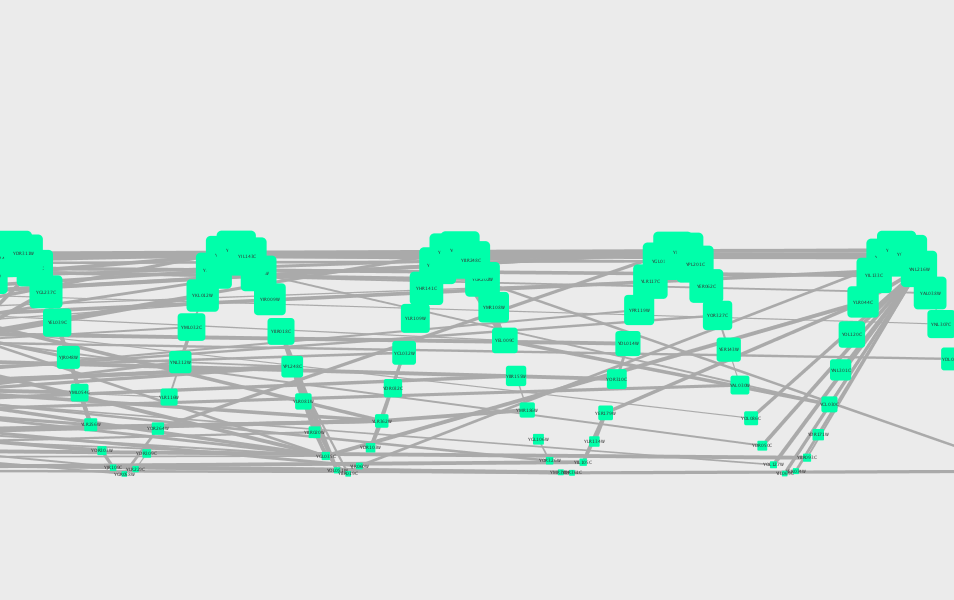

In [72]:
Image(network1.get_png())

In [76]:
from py2cytoscape.cytoscapejs import viewer as cyjs
cyjs.render(network1.get_first_view(), 'default2', background='#efefef')